In [1]:
# pip install lightgbm

import joblib
import os
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from lightgbm import LGBMClassifier

In [2]:
# 번역된 베스트 리뷰 피클 파일 불러오기

b_list = os.listdir('preprocessing/BestReview_Translate')

b = []

for i in b_list:
    if os.path.splitext(i)[1] == '.pkl':
        b.append(i)

In [3]:
# 번역된 워스트 리뷰 피클 파일 불러오기

w_list = os.listdir('preprocessing/WorstReview_Translate')

w = []

for i in w_list:
    if os.path.splitext(i)[1] == '.pkl':
        w.append(i)

In [4]:
# 모든 리뷰를 하나의 리스트로 저장

all = []

for i in range(len(b)):
    all.append(joblib.load('preprocessing/BestReview_Translate/' + b[i]))
    
for i in range(len(w)):
    all.append(joblib.load('preprocessing/WorstReview_Translate/' + w[i]))

In [5]:
# 리뷰의 제목, 리뷰텍스트, 점수를 리스트에 저장

title = []
review = []
score = []

for i in range(len(all)):
    for j in range(all[i]['review number']):
        try:
            score.append(all[i][j]['score'])
            review.append(all[i][j]['review'])
            title.append(all[i]['title'])
            
        except:
            pass

In [221]:
len(review)

14509

In [7]:
# 점수별 리뷰를 데이터프레임으로 변환

df = pd.DataFrame({'Score':score, 'Review':review})
pd.set_option('display.max_rows', 20)
df

,Score,Review
0,10,"Easily one of the best, if not the most well k..."
1,9,"Hands down, one of the best games on DS. Ghost..."
2,10,"Innovative and addictive style of gameplay, en..."
3,10,Phenomenal. This game is the perfect blend of ...
4,10,I picked up this game expecting good things fr...
...,...,...
14504,8,"Too many bugs, too much dynamic difficulty. No..."
14505,6,A great disappointment this year FIFA. I was h...
14506,8,They should have named it FIFA20: Remastered. ...
14507,9,"I have purchased every fifa Game since PS1, an..."


In [236]:
# label data 

df['y'] = df['Score'].apply(lambda x : 1 if int(x) > 7 else 0)
target = df[['y']]
target

,y
0,1
1,1
2,1
3,1
4,1
...,...
14504,1
14505,0
14506,1
14507,1


In [64]:
# X data

X = df.copy()
del X['y']
X

,Score,Review,y
0,10,"Easily one of the best, if not the most well k...",1
1,9,"Hands down, one of the best games on DS. Ghost...",1
2,10,"Innovative and addictive style of gameplay, en...",1
3,10,Phenomenal. This game is the perfect blend of ...,1
4,10,I picked up this game expecting good things fr...,1
...,...,...,...
14504,8,"Too many bugs, too much dynamic difficulty. No...",1
14505,6,A great disappointment this year FIFA. I was h...,0
14506,8,They should have named it FIFA20: Remastered. ...,1
14507,9,"I have purchased every fifa Game since PS1, an...",1


In [103]:
# 정규표현식 적용 함수 정의

def clean(text):
#     alphabet = re.compile('[^ A-Za-z]+')
    alphabet = re.compile(r'[A-Za-z]+')
#     result = alphabet.sub('', text)
    
    result = ' '.join([word if len(word) > 2 else '' \
                            for word in re.findall(alphabet, text)])
    
    return result

In [148]:
X['Review'] = X['Review'].apply(lambda x: clean(x))
X_clean = X.copy()
X_clean['Review'][0]

'Easily one  the best  not the most well known  releases  the year Includes beautiful plot with hints throughout challenging enough  keep you interested without becoming  game  random clicking and  OST which  incredible Shu Takumi has done  excellent job  this game both  aesthetics and  concept   hoping  see  sequel  some form'

In [98]:
# 형태소 분석 함수 정의

def tokenized(text):
    stop_words = stopwords.words("english")
    
    tokens = nltk.word_tokenize(text)
    token = [token for token in tokens if token.lower() not in stop_words]
    return token

In [140]:
result = tokenized(X_clean['Review'][0])
print(result)

['Easily', 'one', 'best', 'well', 'known', 'releases', 'year', 'Includes', 'beautiful', 'plot', 'hints', 'throughout', 'challenging', 'enough', 'keep', 'interested', 'without', 'becoming', 'game', 'random', 'clicking', 'OST', 'incredible', 'Shu', 'Takumi', 'done', 'excellent', 'job', 'game', 'aesthetics', 'concept', 'hoping', 'see', 'sequel', 'form']


In [142]:
# pos-tag 적용 함수 정의

def pos(text):
    
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    
    alphabet = re.compile(r'[A-Za-z]+')
    
    tags = nltk.pos_tag([word if len(word) > 2 else '' for word in re.findall(alphabet, text)])
    
    word_list = []
    
    for word, tag in tags:
        
        if word.lower() not in stop_words:
            
            if tag.startswith('N') or tag.startswith('V') or tag.startswith('R'):
                word_list.append(lemmatizer.lemmatize(word.lower(), tag[0].lower()))
                
            elif tag.startswith('J'):
                word_list.append(lemmatizer.lemmatize(word.lower(), 'a'))
                
            elif tag.startswith('F') or tag.startswith('U'):
                word_list.append(word.lower())
                
    text = ' '.join(word_list)
    
    return text
    

In [150]:
X_clean['Review'] = X_clean['Review'].apply(lambda x: pos(x))
X_pos = X_clean.copy()
X_pos['Review'][0]

'easily best well know release year includes beautiful plot hint challenge enough keep interested become game random clicking ost incredible shu takumi do excellent job game aesthetic concept hop see sequel form'

In [111]:
# 형태소 분석값을 기준으로 CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x: tokenized(x))

X_pos = index_vectorizer.fit_transform(X_pos['Review'].tolist())

print(str(index_vectorizer.vocabulary_)[:100]+" ~")

{'easily': 7552, 'one': 17357, 'best': 2355, 'well': 27787, 'known': 13924, 'releases': 20725, 'year ~


In [245]:
print(X['Review'][0])
print(X_pos[0])

Easily one of the best if not the most well known DS releases of the year Includes beautiful plot with hints throughout challenging enough to keep you interested without becoming a game of random clicking and an OST which is incredible Shu Takumi has done an excellent job on this game both in aesthetics and in concept Im hoping to see a sequel in some form
  (0, 10614)	1
  (0, 25341)	1
  (0, 3416)	1
  (0, 40030)	1
  (0, 20318)	1
  (0, 10323)	1
  (0, 30120)	1
  (0, 40970)	1
  (0, 18336)	1
  (0, 3135)	1
  (0, 27547)	1
  (0, 17271)	1
  (0, 36811)	1
  (0, 5407)	1
  (0, 11367)	1
  (0, 20065)	1
  (0, 18926)	1
  (0, 40482)	1
  (0, 3178)	1
  (0, 14473)	2
  (0, 29354)	1
  (0, 6073)	1
  (0, 25738)	1
  (0, 18394)	1
  (0, 32910)	1
  (0, 35862)	1
  (0, 9983)	1
  (0, 12085)	1
  (0, 19710)	1
  (0, 619)	1
  (0, 6767)	1
  (0, 18035)	1
  (0, 17514)	1
  (0, 32138)	1
  (0, 32360)	1
  (0, 13848)	1


In [155]:
# TF-IDF 적용

tfidf_vectorizer = TfidfTransformer()
X_pos = tfidf_vectorizer.fit_transform(X_pos)

print(X_pos.shape)
print(X_pos[0])

(14509, 24164)
  (0, 23977)	0.10523835963173729
  (0, 23490)	0.09201922585162135
  (0, 20985)	0.2850837207947827
  (0, 19255)	0.2811348290397458
  (0, 18941)	0.15764517599458258
  (0, 18798)	0.11001646515037888
  (0, 17608)	0.127951846812576
  (0, 17129)	0.19514020924308612
  (0, 16067)	0.14164250913925125
  (0, 15035)	0.22501170655594338
  (0, 11823)	0.11860747008722917
  (0, 11670)	0.1310662796267312
  (0, 11413)	0.1585950080600313
  (0, 11013)	0.1987682676454478
  (0, 10635)	0.1479533156876983
  (0, 10584)	0.33156177548383947
  (0, 10049)	0.19319204461206896
  (0, 9902)	0.217530410755884
  (0, 8492)	0.07925496055754322
  (0, 8122)	0.18485651586317928
  (0, 7156)	0.14089552231250382
  (0, 6706)	0.13728932685809983
  (0, 6249)	0.15111371225997197
  (0, 3933)	0.1854951414483404
  (0, 3517)	0.3083227481393111
  (0, 3142)	0.1382731963168325
  (0, 1992)	0.07370022112508885
  (0, 1856)	0.1457151028472289
  (0, 1843)	0.13098161587086887
  (0, 357)	0.2264385954923623


In [156]:
# 학습 데이터셋과 테스트 데이터셋으로 분리

X_train, X_test, y_train, y_test = train_test_split(X_pos, target, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(10156, 24164)
(4353, 24164)


In [157]:
# 로지스틱 회귀 모델 적용

LR_model = LogisticRegression(random_state=0)
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
y_pred_proba = LR_model.predict_proba(X_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Programming\ANACONDA\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


accuracy: 0.87
              precision    recall  f1-score   support

           0       0.76      0.10      0.17       593
           1       0.87      1.00      0.93      3760

    accuracy                           0.87      4353
   macro avg       0.82      0.55      0.55      4353
weighted avg       0.86      0.87      0.83      4353



In [158]:
# 혼동행렬 출력

matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
matrix

array([[  58,  535],
       [  18, 3742]], dtype=int64)

0.8842291270496214


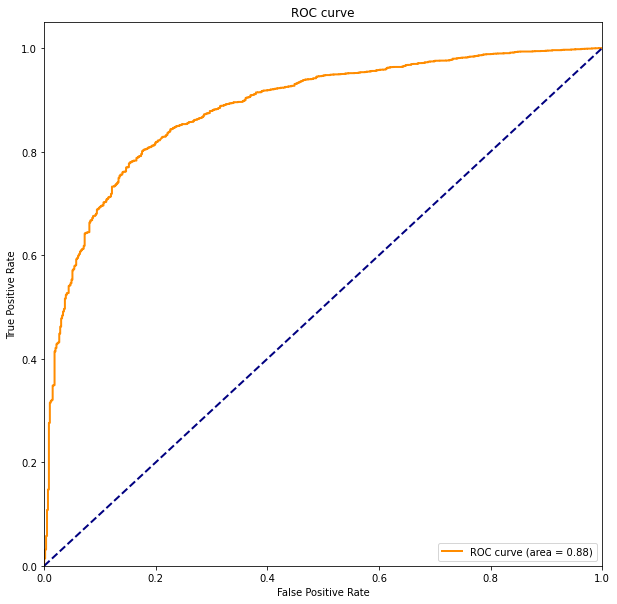

In [159]:
# 로지스틱 회귀 ROC curve 출력

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("LR ROC curve")
plt.show()

In [160]:
# 라벨 데이터 수 확인

df['y'].value_counts()

1    12601
0     1908
Name: y, dtype: int64

In [162]:
# 데이터 균등화를 위한 샘플데이터 생성

PRI = df[ df['y'] == 1 ].sample(1000, random_state=42).index.tolist()
NRI = df[ df['y'] == 0 ].sample(1000, random_state=42).index.tolist()

RI = PRI + NRI
len(RI)

2000

In [164]:
# 리샘플링 데이터 스플릿

sample_X_pos = X_pos[RI, :]
sample_target = df['y'][RI]

X_train, X_test, y_train, y_test = train_test_split(sample_X_pos, sample_target, test_size=0.30, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(1400, 24164)
(600, 24164)


In [125]:
# 리샘플링 데이터로 로지스틱 회귀 모델 재분석

LR_model = LogisticRegression(random_state=0)
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
y_pred_proba = LR_model.predict_proba(X_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy: 0.80
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       292
           1       0.85      0.73      0.79       308

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



In [126]:
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
matrix

array([[253,  39],
       [ 83, 225]], dtype=int64)

0.8686399217221135


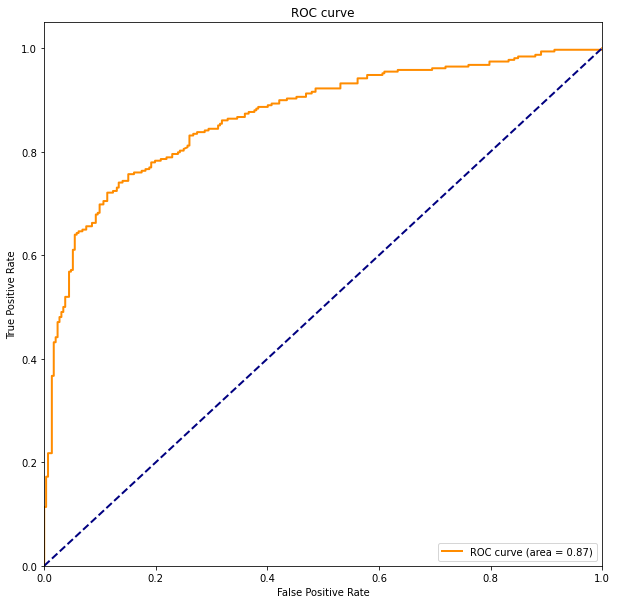

In [127]:
# 리샘플링 데이터로 로지스틱 회귀 모델 ROC curve 출력

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("LR ROC curve")
plt.show()

<BarContainer object of 24164 artists>

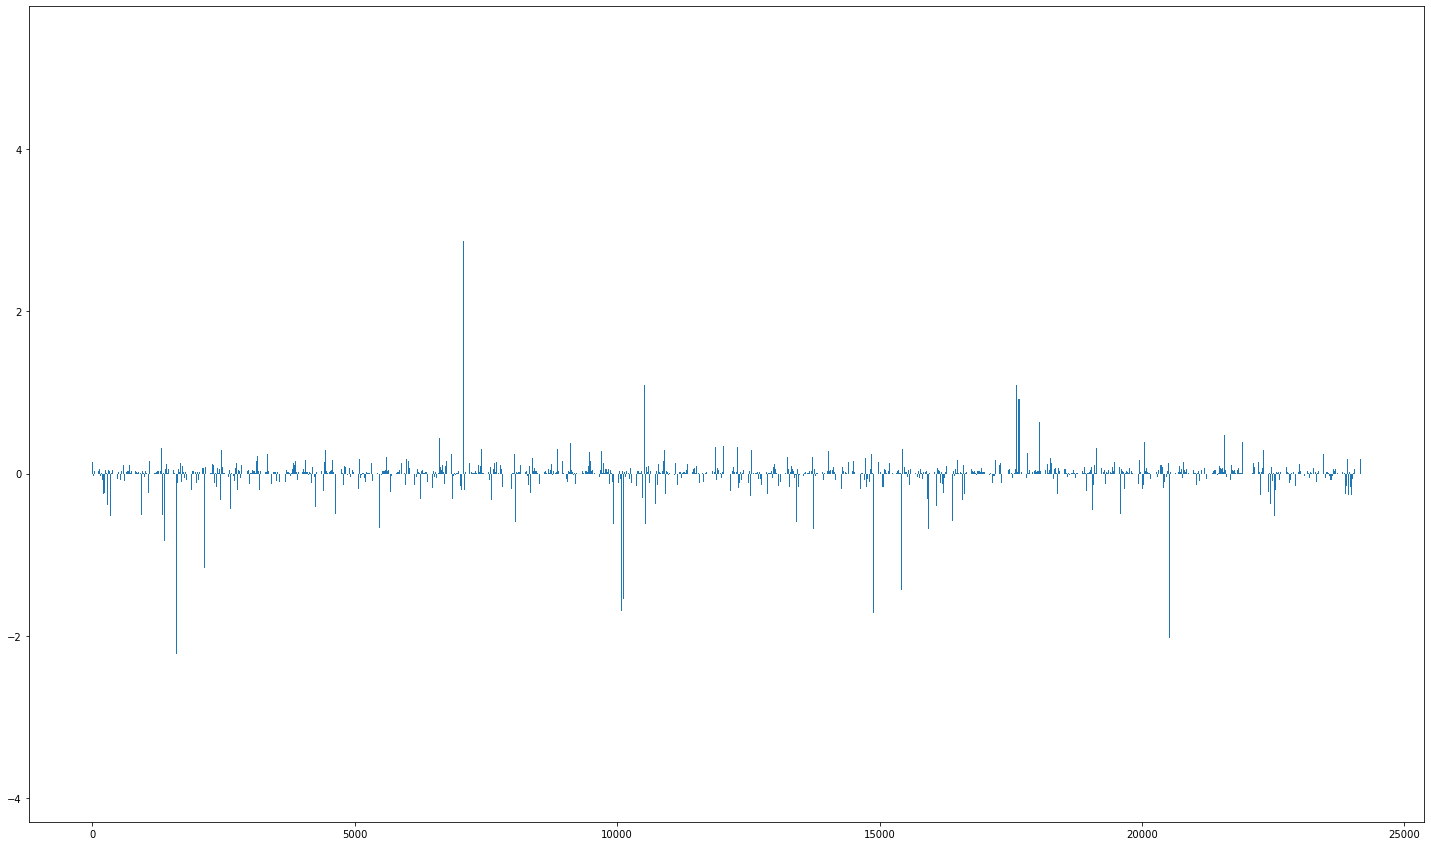

In [165]:
# 단어별 상관관계 그래프 출력

plt.rcParams['figure.figsize'] = [25, 15]
# plt.gca().set_facecolor('#000000') # 그래프 배경색 설정
plt.bar(range(len(LR_model.coef_[0])), LR_model.coef_[0])

In [166]:
# 상관관계 값과 단어 벡터 출력

print(sorted(((value, index) for index, value in enumerate(LR_model.coef_[0])), reverse = True)[:10])
print(sorted(((value, index) for index, value in enumerate(LR_model.coef_[0])), reverse = True)[-10:])

[(5.301483721885306, 1992), (3.29562448416908, 15621), (3.2231704646795447, 692), (3.203828922276679, 9191), (2.9217137091395364, 12980), (2.8673715604460868, 7071), (2.7866886411285092, 1527), (2.27226027211135, 7623), (2.2435477304001448, 687), (2.2397885382313, 7156)]
[(-2.0218309342742344, 20523), (-2.0539382724181756, 18360), (-2.156711253258416, 16200), (-2.219684208252482, 15192), (-2.222372757028702, 1603), (-2.331234442302216, 15191), (-2.527338637767439, 1495), (-2.7062568093726935, 2353), (-2.9578410813378375, 17753), (-3.8354268204450506, 2357)]


In [167]:
# 벡터값을 단어로 변환

coef_index = sorted(((value, index) for index, value in enumerate(LR_model.coef_[0])), reverse = True)
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

In [169]:
# 긍정 단어 10개 출력

for coef in coef_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])

best 5.301483721885306
perfect 3.29562448416908
amazing 3.2231704646795447
great 3.203828922276679
masterpiece 2.9217137091395364
ever 2.8673715604460868
awesome 2.7866886411285092
favorite 2.27226027211135
amaze 2.2435477304001448
excellent 2.2397885382313


In [170]:
# 부정 단어 10개 출력

for coef in coef_index[-1:-11:-1]:
    print(invert_index_vectorizer[coef[1]], coef[0])

boring -3.8354268204450506
repetitive -2.9578410813378375
bore -2.7062568093726935
average -2.527338637767439
overrate -2.331234442302216
bad -2.222372757028702
overrated -2.219684208252482
poor -2.156711253258416
ruin -2.0539382724181756
stupid -2.0218309342742344
score -2.0114460334539213
cheater -1.8953805085822875
clunky -1.8899623462578303
run -1.881033826186109
short -1.82482965709398
nothing -1.813841984931818
understand -1.730069749772336
open -1.723366252041263
horrible -1.6930229398993337
terrible -1.669310574134524


In [ ]:
# LGBM 모델 적용

LGBM_model = LGBMClassifier()
LGBM_model.fit(X_train, y_train, eval_metric='logloss')
y_pred = LGBM_model.predict(X_test)
y_pred_proba = LGBM_model.predict_proba(X_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
matrix

In [ ]:
# LGBM 모델 ROC curve 출력

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

In [ ]:
# 그리드 서치 점수 분석

LGBM_parameters = {'n_estimators': [500,1000],
                  'max_depth': [2,4,8],
                  'learning_rate': [0.01, 0.1, 1]}

grid_LGBM = GridSearchCV(LGBM_model, param_grid=LGBM_parameters, refit = True, return_train_score = True)

grid_LGBM.fit(X_train,y_train)

LGBM_scores_df = pd.DataFrame(grid_LGBM.cv_results_)


print('Best Parameter : ', grid_LGBM.best_params_)
print('Best score : ', grid_LGBM.best_score_)

LGBM_estimator = grid_LGBM.best_estimator_

LGBM_scores_df